# FEISTY Data Processing from CESM2-LE derived output
- Process data for Southern Ocean forage, demersal, and benthic groups. These FEISTY data were already calculated monthly and then averaged over the year.
- Notebook by Alice DuVivier (NCAR), Kristen Krumhardt (NCAR)
- Note: this notebook needs to load the utils.py file
- May 2024

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import pop_tools 
import dask
from distributed import Client
from ncar_jobqueue import NCARCluster
import utils
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs

## Spin up DASK cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client
# cluster.close()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/42929/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/42929/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.105:42843,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/42929/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load the FEISTY data

In [4]:
# load grid information
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA
area_m = ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [5]:
# load FEISTY files for 1850-2100
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'
files = sorted(glob(f'{path}/CESM2-LE-FEISTY-HIST-SSP370-cmip6-ensmem-????????_1850-2100.nc'))        
ds = xr.open_mfdataset(files,concat_dim="member_id", coords='minimal', compat="override", combine='nested')

In [6]:
ds

,Array,Chunk
Bytes,103.41 GiB,2.07 GiB
Shape,"(50, 251, 9, 384, 320)","(1, 251, 9, 384, 320)"
Count,200 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,91.92 GiB,1.84 GiB
Shape,"(50, 251, 8, 384, 320)","(1, 251, 8, 384, 320)"
Count,200 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


### Subset data as needed

In [7]:
## Enter the years you want to keep:
yy_st = "1950"
yy_ed = "2100"

years_all = np.arange(1850,2101,1)

In [8]:
# cut data so we just keep the years of interest
ds['time'] = years_all
ds = ds.sel(time=slice(yy_st,yy_ed))

#years = np.arange(int(yy_st),int(yy_ed),1)

In [9]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [10]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds = ds.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

### Sum up the different fish types

In [11]:
ds.group

<xarray.DataArray 'group' (group: 9)>
array(['Sf', 'Sp', 'Sd', 'Mf', 'Mp', 'Md', 'Lp', 'Ld', 'benthic_prey'],
      dtype=object)
Coordinates:
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'

In [12]:
# sum up all sizes for each type of fish to get total biomass in that category

ds_biomass_types = xr.Dataset()

ds_biomass_types['Forage'] = ds.biomass.sel(group='Mf') + ds.biomass.sel(group='Sf')
ds_biomass_types['Pelagic'] = ds.biomass.sel(group='Lp') + ds.biomass.sel(group='Mp') + ds.biomass.sel(group='Sp')
ds_biomass_types['Demersal'] = ds.biomass.sel(group='Ld') + ds.biomass.sel(group='Md') + ds.biomass.sel(group='Sd')
ds_biomass_types['Benthic'] = ds.biomass.sel(group='benthic_prey')

In [13]:
ds_biomass_types.load()

<xarray.Dataset>
Dimensions:   (nlat: 36, nlon: 320, time: 151, member_id: 50)
Coordinates:
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time      (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
    group     <U2 'Sp'
Dimensions without coordinates: member_id
Data variables:
    Forage    (member_id, time, nlat, nlon) float64 nan nan ... 0.8072 0.8065
    Pelagic   (member_id, time, nlat, nlon) float64 nan nan nan ... 0.1936 0.191
    Demersal  (member_id, time, nlat, nlon) float64 nan nan ... 0.07207 0.07088
    Benthic   (member_id, time, nlat, nlon) float64 nan nan ... 0.2198 0.2187

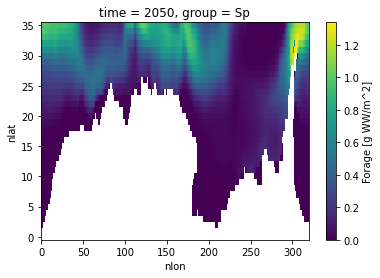

In [27]:
ds_biomass_types['Forage'].isel(time=100,member_id=0).plot()

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon)
- Include TAREA, andd TLAT and TLONG as coordinates
- One netcdf per variable per time period: ONDJFM (whole growing season), OND (early), JFM (late)

In [15]:
# load grid data to include in output file
dir_in = '/glade/u/home/duvivier/masks/'
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [16]:
ds_out = ds_biomass_types
ds_out['TAREA'] = ds_grid.TAREA

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'yearly FEISTY biomass in the Southern Ocean from 1950 to 2099 from the CESM2 Large Ensemble.'

ds_out

<xarray.Dataset>
Dimensions:   (nlat: 36, nlon: 320, time: 151, member_id: 50)
Coordinates:
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time      (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
    group     <U2 'Sp'
    ULONG     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT      (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Dimensions without coordinates: member_id
Data variables:
    Forage    (member_id, time, nlat, nlon) float64 nan nan ... 0.8072 0.8065
    Pelagic   (member_id, time, nlat, nlon) float64 nan nan nan ... 0.1936 0.191
    Demersal  (member_id, time, nlat, nlon) float64 nan nan ... 0.07207 0.07088
    Benthic   (member_id, time, nlat, nlon) float64 nan nan ... 0.2198 0.2187
    TAREA     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-06-19
    contents:        yearly FEISTY biomass in the Southern Ocean from 1950 to...

In [17]:
# drop the ULAT/ULONG variables
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')
ds_out = ds_out.drop('group')

In [18]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	nlat: (36,)
	nlon: (320,)
	time: (151,)
	member_id: (50,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 

## Export and Save

In [19]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 2.59 GB.


In [20]:
variable = 'FEISTY'

path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'
file_out = 'CESM2-LE-annual-mean-'+variable+'.nc'
fout = path_out + file_out

In [21]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [22]:
cluster.close()